In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Пропусков нет, тип данных Month - object, мне нужен datetime

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [5]:
df.set_index('Month', inplace=True)

In [6]:
df.index.is_monotonic_increasing

True

У меня соблюдён хронологический порядок

Оставьте для аналитики лишь с 1952 по 1957 год (включительно)

In [7]:
data = df['1952':'1957']
print(data.index.min(), data.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


In [8]:
decomposed = seasonal_decompose(data['#Passengers'])

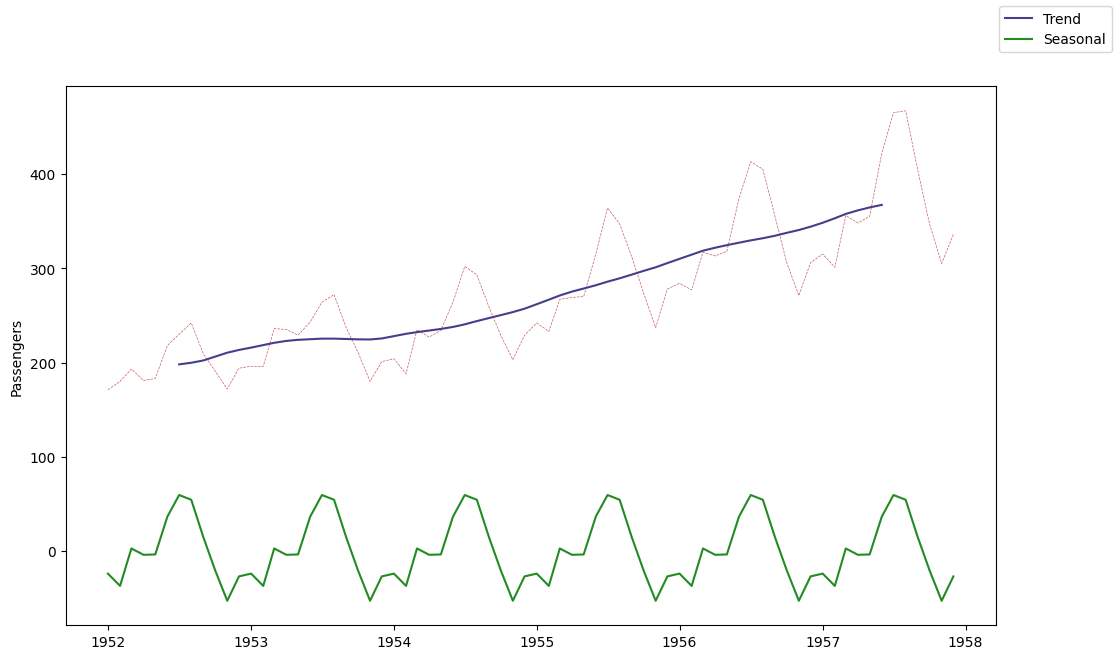

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[12, 7])

ax.plot(data['#Passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.set_ylabel('Passengers')

fig.legend()

На данном графике наблюдается тренд - количество пассажиров с каждым годом увеличивается, а также прослеживается сезонность причем ежегодная, ряд является НЕ стационарным, так как со временем меняется среднее и амплитуда

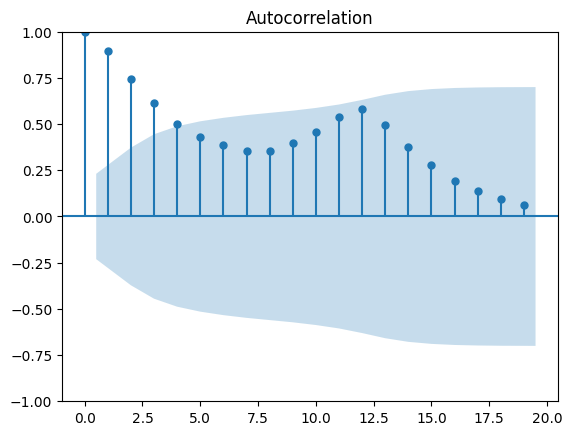

In [10]:
fig = tsaplots.plot_acf(data['#Passengers'])
plt.show() 

Самая сильная автокорреляция у первого сдвига, значит, каждый следующий месяц похож на предыдущий, что подтверждает тренд
После первого лага автокорреляция падает и её пик приходится на 12 лаг - подтверждение ежегодной сезонности

In [19]:
def make_features(data, max_lag=(1,3,6,12), window=(3,6,12)):
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year

    for i in max_lag:
        data[f'lag_{i}'] = data['#Passengers'].shift(i)

    for i in window:
        data[f'rolling_mean_{i}'] = data['#Passengers'].rolling(i).mean().shift(1)

    return data

In [20]:
data_with_feature = make_features(data.copy())
data_with_feature.head()

,#Passengers,quarter,month,year,lag_1,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_6,rolling_mean_12
Month,,,,,,,,,,,
1952-01-01,171,1,1,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,1,2,1952,171.0,NaN,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,1,3,1952,180.0,NaN,NaN,NaN,NaN,NaN,NaN
1952-04-01,181,2,4,1952,193.0,171.0,NaN,NaN,181.333333,NaN,NaN
1952-05-01,183,2,5,1952,181.0,180.0,NaN,NaN,184.666667,NaN,NaN


In [21]:
train, test = train_test_split(data_with_feature.dropna(), shuffle=False, test_size=0.2)

train_target = train['#Passengers']
train_feature = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_feature = test.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_feature)
train_norm = scaler.transform(train_feature)
test_norm = scaler.transform(test_feature)

model = LinearRegression()
model.fit(train_norm, train_target)

train_predict = pd.Series(model.predict(train_norm))
train_predict.index = train_feature.index
test_predict = pd.Series(model.predict(test_norm))
test_predict.index = test_feature.index

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_predict))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_predict))

MAE обучающей выборки: 9.799998189892905
MAE тестовой выборки:  10.77029813705596


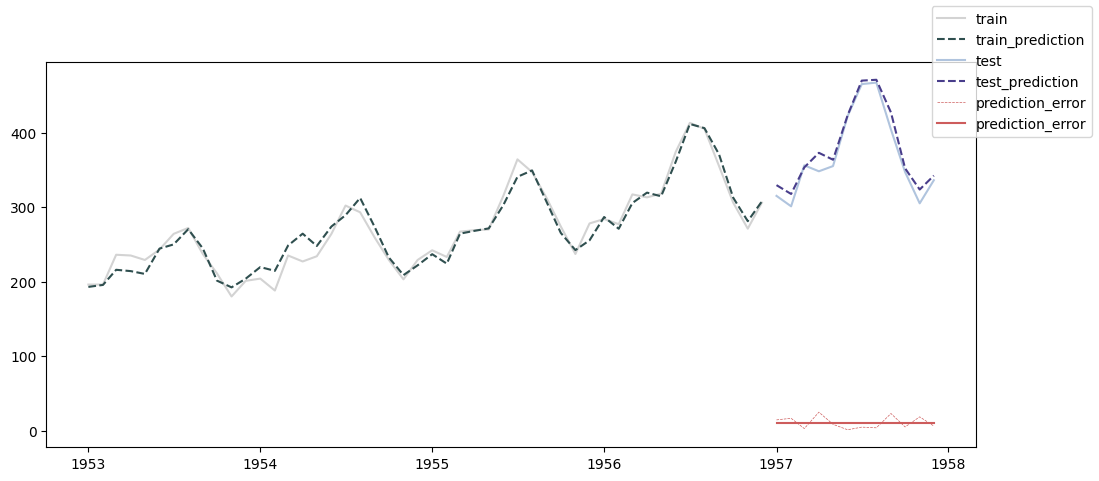

In [22]:
fig, ax = plt.subplots(1, 1, figsize=[12,5])

error = abs(test['#Passengers']-test_predict)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_predict, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_predict, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

Предсказания, как на тренировочных, так и на тестовых данных очень близки  креальным, MAE достаточно низкое

In [30]:
data_with_feature_all = make_features(df.copy())
data_with_feature_all.dropna(inplace=True)

In [32]:
data_last_with_feature = data_with_feature_all['1958':'1960']
data_last_with_feature.head()

,#Passengers,quarter,month,year,lag_1,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_6,rolling_mean_12
Month,,,,,,,,,,,
1958-01-01,340,1,1,1958,336.0,347.0,465.0,315.0,329.333333,387.333333,368.416667
1958-02-01,318,1,2,1958,340.0,305.0,467.0,301.0,327.000000,366.500000,370.500000
1958-03-01,362,1,3,1958,318.0,336.0,404.0,356.0,331.333333,341.666667,371.916667
1958-04-01,348,2,4,1958,362.0,340.0,347.0,348.0,340.000000,334.666667,372.416667
1958-05-01,363,2,5,1958,348.0,318.0,305.0,355.0,342.666667,334.833333,372.416667


In [37]:
train_last, test_last = train_test_split(data_last_with_feature, shuffle=False, test_size=0.2)

train_target_last = train_last['#Passengers']
train_feature_last = train_last.drop(['#Passengers'], axis=1)
test_target_last = test_last['#Passengers']
test_feature_last = test_last.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_feature_last)
train_norm_last = scaler.transform(train_feature_last)
test_norm_last = scaler.transform(test_feature_last)

model.fit(train_norm_last, train_target_last)

train_predict_last = pd.Series(model.predict(train_norm_last))
train_predict_last.index = train_feature_last.index
test_predict_last = pd.Series(model.predict(test_norm_last))
test_predict_last.index = test_feature_last.index

print("MAE тестовой выборки: " , mean_absolute_error(test_target_last, test_predict_last))

MAE тестовой выборки:  23.590873299582583


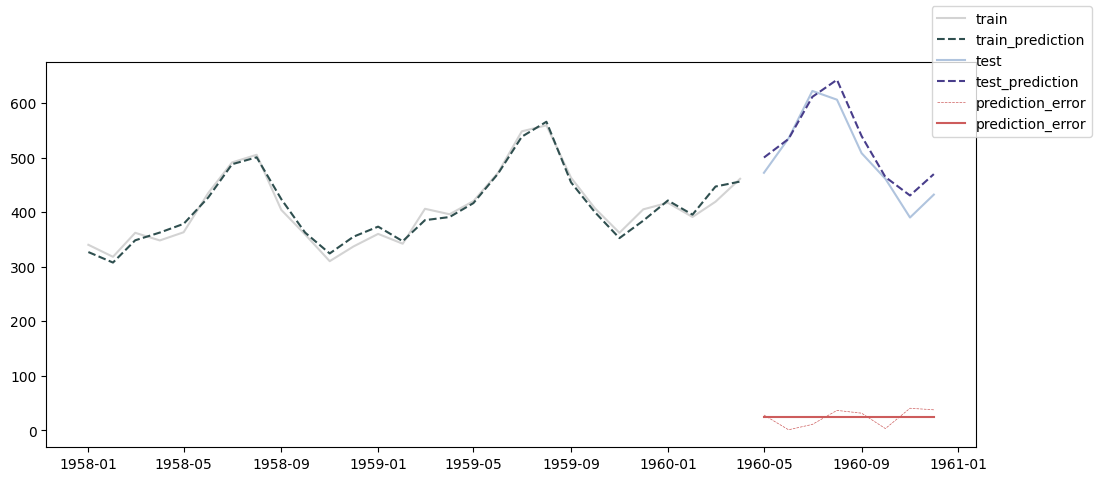

In [38]:
fig, ax = plt.subplots(1, 1, figsize=[12,5])

error_last = abs(test_last['#Passengers']-test_predict_last)
error_mean_last = pd.Series([error_last.mean()] * error_last.shape[0])
error_mean_last.index = test_last.index

ax.plot(train_target_last, c='lightgrey', label='train')
ax.plot(train_predict_last, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target_last, c='lightsteelblue', label='test')
ax.plot(test_predict_last, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error_last, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean_last, c='indianred', label='prediction_error')

fig.legend()

Модель предсказывает пассажиропоток в 1958–1960 гг. хорошо, MAE соответствует условию, график подтверждает адекватность прогноза